# Ab Initio Molecular Dynamics using VASP and ASE

Authors: <br>
[Prof. Elvis do A. Soares](https://github.com/elvissoares) <br>
[PhD. Hugo de L. C. Neto](https://github.com/hugo-neto) <br>

Contacts: <br>
[elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/) <br>
[hneto@peq.coppe.ufrj.br](mailto:hneto@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

# Useful Links

https://www.vasp.at/tutorials/latest/md/part2/ <br>
https://www.vasp.at/wiki/index.php/Best_practices_for_machine-learned_force_fields

# Importing Libraries

In [93]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/hugo/Documents/Programs/VASP/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std_gpu_mlff'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

In [94]:
# Importing the VASP calculator of ASE
from ase.calculators.vasp import Vasp

from ase import Atoms
from ase.build import molecule
from ase.io import write, read
from ase.visualize import view

from py4vasp import plot

import matplotlib.pyplot as plt
import numpy as np


# Post-Treatment

## Functions

In [95]:
def read_ml_reg_energies(filename="ML_REG"):
    e_dft = []
    e_ml  = []

    in_block = False

    with open(filename, "r") as f:
        for line in f:
            # Detect start of energy block
            if "Total energies" in line:
                in_block = True
                continue

            # Detect end of block
            if in_block and (line.strip() == "" or line.startswith("===")):
                break

            if in_block:
                parts = line.split()
                if len(parts) >= 2:
                    try:
                        e_dft.append(float(parts[0]))
                        e_ml.append(float(parts[1]))
                    except ValueError:
                        # skip headers or non-numeric lines
                        pass

    return np.array(e_dft), np.array(e_ml)


def read_ml_reg_2col_block(filename, header_substring):
    """
    Extract a 2-column numeric block (DFT, ML) from ML_REG.
    Stops when numeric data ends.
    """
    x_dft, x_ml = [], []
    in_block = False

    with open(filename, "r") as f:
        for line in f:
            # Start when we see the block header
            if header_substring in line:
                in_block = True
                continue

            if not in_block:
                continue

            parts = line.split()

            # Try to read 2 floats from each data line
            if len(parts) >= 2:
                try:
                    a = float(parts[0])
                    b = float(parts[1])
                    x_dft.append(a)
                    x_ml.append(b)
                    continue
                except ValueError:
                    # header/separator lines inside the block
                    pass

            # If we've already collected data and now hit non-numeric lines, end block
            if x_dft:
                break

    return np.array(x_dft), np.array(x_ml)

## Plot the Bayesian error and in-sample error of the FORCES using the following code

In [ ]:
! grep BEEF ./servidor/ML_LOGFILE > ./servidor/BEEF.dat

t1, beef = np.loadtxt("./servidor/BEEF.dat",
                      usecols=[1,3], unpack=True)

g = plot(t1[5:], beef[5:],
    xlabel="Time step",
    xlabel_kwargs={"fontsize":30},
    ylabel="Bayesian error",
    title=r"Bayesian error estimate of forces (max) (eV Å⁻¹)"
)

fig = g.to_plotly()  # convert py4vasp Graph -> plotly figure :contentReference[oaicite:0]{index=0}

# Axis title sizes
fig.update_xaxes(title_font=dict(size=28))
fig.update_yaxes(title_font=dict(size=28))

# Plot title size
fig.update_layout(title=dict(font=dict(size=28)))

# (Optional) tick label sizes
fig.update_xaxes(tickfont=dict(size=20))
fig.update_yaxes(tickfont=dict(size=20))

fig.write_image("Cel_B_NVT_300K_VASP_F_Bay.png", scale=3)
fig.show()

In [ ]:
! grep ERR ./servidor/ML_LOGFILE > ./servidor/ERR.dat

t2, inerr = np.loadtxt("./servidor/ERR.dat", 
                       usecols=[1,3], unpack=True)

g = plot(t2[5:], inerr[5:],
    xlabel="Time step",
    ylabel="RMSE",
    title=r"Root mean squared error of forces (eV Å⁻¹)"
)

fig = g.to_plotly()  # convert py4vasp Graph -> plotly figure :contentReference[oaicite:0]{index=0}

# Axis title sizes
fig.update_xaxes(title_font=dict(size=28))
fig.update_yaxes(title_font=dict(size=28))

# Plot title size
fig.update_layout(title=dict(font=dict(size=28)))

# (Optional) tick label sizes
fig.update_xaxes(tickfont=dict(size=20))
fig.update_yaxes(tickfont=dict(size=20))

fig.write_image("Cel_B_NVT_300K_VASP_F_RMS.png", scale=3)
fig.show()

## Plot the Bayesian error and in-sample error of the ENERGIES using the following code

In [ ]:
! grep BEEF ./servidor/ML_LOGFILE > ./servidor/BEEF.dat

t1, beef = np.loadtxt("./servidor/BEEF.dat",
                      usecols=[1,2], unpack=True)

g = plot(t1[5:], beef[5:],
    xlabel="Time step",
    xlabel_kwargs={"fontsize":30},
    ylabel="Bayesian error",
    title=r"Bayesian error estimate of energies (max) (eV)"
)

fig = g.to_plotly()  # convert py4vasp Graph -> plotly figure :contentReference[oaicite:0]{index=0}

# Axis title sizes
fig.update_xaxes(title_font=dict(size=28))
fig.update_yaxes(title_font=dict(size=28))

# Plot title size
fig.update_layout(title=dict(font=dict(size=28)))

# (Optional) tick label sizes
fig.update_xaxes(tickfont=dict(size=20))
fig.update_yaxes(tickfont=dict(size=20))

fig.write_image("Cel_B_NVT_300K_VASP_E_Bay.png", scale=3)
fig.show()

In [ ]:
! grep ERR ./servidor/ML_LOGFILE > ./servidor/ERR.dat

t2, inerr = np.loadtxt("./servidor/ERR.dat", 
                       usecols=[1,2], unpack=True)

g = plot(t2[5:], inerr[5:],
    xlabel="Time step",
    ylabel="RMSE",
    title=r"Root mean squared error of energies (eV)"
)

fig = g.to_plotly()  # convert py4vasp Graph -> plotly figure :contentReference[oaicite:0]{index=0}

# Axis title sizes
fig.update_xaxes(title_font=dict(size=28))
fig.update_yaxes(title_font=dict(size=28))

# Plot title size
fig.update_layout(title=dict(font=dict(size=28)))

# (Optional) tick label sizes
fig.update_xaxes(tickfont=dict(size=20))
fig.update_yaxes(tickfont=dict(size=20))

fig.write_image("Cel_B_NVT_300K_VASP_E_RMS.png", scale=3)
fig.show()

## Plot the difference in energy DFT x MLFF (from ML_REG file)

In [ ]:
actual_dir  = os.getcwd()
data_dir    = os.path.join(actual_dir, "servidor", "ML_REG")

In [ ]:
e_dft, e_ml = read_ml_reg_energies(data_dir)
frames      = np.arange(1,len(e_dft)+1)

In [ ]:
# Note: Cellulose Beta has 84 atoms
# That's why we divide by 84 to get eV/atom
vasp_energies = e_dft/84
mace_energies = e_ml/84

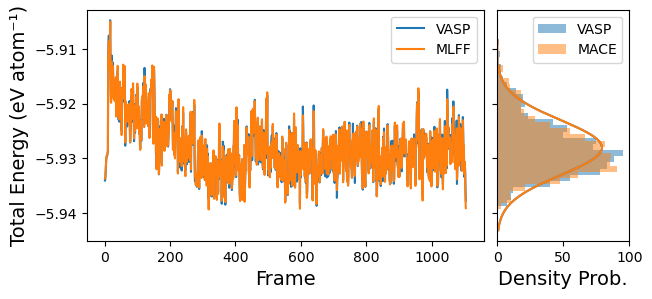

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(7,3), sharey=True, gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.05} )

axs[0].plot(frames, vasp_energies, label='VASP')
axs[0].plot(frames, mace_energies, label='MLFF')
axs[0].legend()
axs[0].set_xlabel('Frame', fontsize=14)
axs[0].set_ylabel('Total Energy (eV atom⁻¹)', fontsize=14)

axs[1].hist(vasp_energies,bins=30,density=True, color='C0', alpha=0.5, label='VASP', orientation="horizontal")
axs[1].hist(mace_energies,bins=30,density=True, color='C1', alpha=0.5, label='MACE', orientation="horizontal")

Umean = np.mean(vasp_energies)
sigmaU = np.std(vasp_energies)
uarray = Umean+np.arange(-3*sigmaU,3*sigmaU,0.01*sigmaU)
axs[1].plot(np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),uarray, color='C0')
Umean = np.mean(mace_energies)
sigmaU = np.std(mace_energies)
uarray = Umean+np.arange(-3*sigmaU,3*sigmaU,0.01*sigmaU)
axs[1].plot(np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),uarray, color='C1')
axs[1].legend()
axs[1].set_xlabel('Density Prob.', fontsize=14)

plt.savefig("Energy_Comparison_VASPMLFF_VASP_Cellulose_Beta.png", dpi=300, bbox_inches='tight')

Computing the RMSE between MLFF and DFT of energies and forces

In [ ]:
RMSE = np.sqrt(np.mean((mace_energies-vasp_energies)**2))

print("RMSE between energies of VASP MLFF and VASP DFT: {:.4f} eV/átomo".format(RMSE))

RMSE between energies of VASP MLFF and VASP DFT: 0.0007 eV/átomo


In [ ]:
f_dft, f_ml = read_ml_reg_2col_block(data_dir, "Forces")
#f_dft, f_ml = f_dft/84, f_ml/84 # I'm dividing by number of atoms to get eV/Å per atom

rmse_F = np.sqrt(np.mean((f_dft - f_ml)**2))
print("RMSE between forces of VASP MLFF and VASP: {:.4f} eV/Å".format(rmse_F))

IsADirectoryError: [Errno 21] Is a directory: '/media/hugo/2TB_Kirby/Drive/Drive_do_Rato_PEQ/3 - Terceiro Período/COQ-878-Quimica Quantica Computacional/COQ-878/FinalWork/MLFF_VASP/BO-AIMD_MLFF6/servidor'

## Computing Energy and Temperature at each frame

Using py4vasp to read the inputs

In [82]:
from py4vasp import Calculation

In [83]:
actual_dir  = os.getcwd()
data_dir    = os.path.join(actual_dir, "servidor")

In [84]:
my_calc     = Calculation.from_path(data_dir)

In [85]:
# Note: Cellulose Beta has 84 atoms
# That's why we divide by 84 to get eV/atom
toten = my_calc.energy[:].to_numpy("TOTEN")/84
temp  = my_calc.energy[:].to_numpy("temperature")
steps = np.arange(1, len(toten)+1)

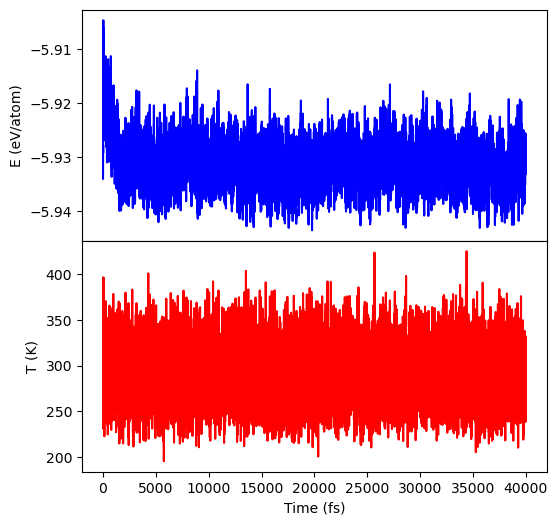

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})            
ax[0].plot(steps/2, toten, color="b") #!!**!! assuming 0.5 fs time step
ax[0].set_ylabel('E (eV/atom)')

# plot the temperature of the system as subplots
ax[1].plot(steps/2, temp, color="r")  #!!**!! assuming 0.5 fs time step
ax[1].set_ylabel('T (K)')
ax[1].set_xlabel('Time (fs)')
plt.savefig("Cellulose_Beta_NVT_300K_VASPMLFF.png", dpi=300, bbox_inches='tight')